# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [76]:
# You can set them inline
import os
os.environ["MISTRAL_API_KEY"] = "MISTRAL_API_KEY"
os.environ["LANGSMITH_API_KEY"] = "LANGSMITH_API_KEY"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [77]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

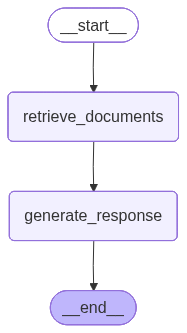

In [78]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_mistralai.chat_models import ChatMistralAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatMistralAI(model="mistral-small-latest", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [79]:
question = "How can I use LangSmith to evaluate my ML model's performance?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"custom_experiment": "model_eval", "user": "rakshit"}})

{'question': "How can I use LangSmith to evaluate my ML model's performance?",
 'messages': [HumanMessage(content="How can I use LangSmith to evaluate my ML model's performance?", additional_kwargs={}, response_metadata={}),
  AIMessage(content="To evaluate your ML model's performance using LangSmith, you can use prebuilt LLM-as-judge evaluators from the open-source openevals package or define custom evaluators. First, install the required dependencies like `langsmith` and `openevals`, then set up environment variables for tracing. Create a dataset with input and reference output pairs to test your model's responses.", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 1195, 'total_tokens': 1274, 'completion_tokens': 79}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop'}, id='run--03ec59f5-ce34-4ccc-8c8e-0df340a9b9c3-0', usage_metadata={'input_tokens': 1195, 'output_tokens': 79, 'total_tokens': 1274})],
 'documents': 

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [80]:
from langsmith import traceable, trace
from langchain_mistralai.chat_models import ChatMistralAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "mistral"
MODEL_NAME = "mistral-small-latest"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

mistral_client = ChatMistralAI(model=MODEL_NAME)
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_mistral` to generate a model response after formatting inputs
"""
# TODO: Remove traceable, and use with trace()
@traceable
def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    # with trace(
    #     name="Generate Response",
    #     run_type="chain", 
    #     inputs={"question": question, "formatted_docs": formatted_docs},
    #     metadata={"foo": "bar"},
    # ) as ls_trace:
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    response = call_mistral(messages)
    # TODO: End your trace and write outputs to LangSmith
    # ls_trace.end(outputs={"output": response})
    return response

"""
call_mistral
- Returns the chat completion output from Mistral AI
"""
@traceable
def call_mistral(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    from langchain_core.messages import HumanMessage, SystemMessage
    
    # Convert dict messages to LangChain message objects
    langchain_messages = []
    for msg in messages:
        if msg["role"] == "system":
            langchain_messages.append(SystemMessage(content=msg["content"]))
        elif msg["role"] == "user":
            langchain_messages.append(HumanMessage(content=msg["content"]))
    
    response = mistral_client.invoke(langchain_messages)
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content


In [81]:
question = "What are the best practices for debugging LLM applications using tracing?"
ai_answer = langsmith_rag(question)
print(f"AI Response: {ai_answer}")
print(f"Question asked: {question}")

AI Response: To debug LLM applications using tracing, you can attach feedback to traces, which can come from users, annotators, or automated evaluators. This feedback is crucial for monitoring and evaluating applications. You can use the `create_feedback()` or `createFeedback()` function to log feedback using the SDK. Additionally, you can attach user feedback to any child run of a trace, not just the root run, which is useful for critiquing specific steps of the LLM application.
Question asked: What are the best practices for debugging LLM applications using tracing?


## Mistral AI Integration

In this section, we demonstrate how to integrate Mistral AI with LangSmith tracing using the @traceable decorator. The decorator works seamlessly with Mistral AI clients and allows you to automatically log traces without requiring function wrapping.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [82]:
# Mistral AI Integration with LangSmith Tracing
# Using @traceable decorator with Mistral AI ChatMistralAI client
from langchain_mistralai.chat_models import ChatMistralAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "mistral"
MODEL_NAME = "mistral-small-latest"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# Use Mistral AI client directly
mistral_client = ChatMistralAI(model=MODEL_NAME)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_mistral(messages)

@traceable
def call_mistral(
    messages: List[dict],
) -> str:
    from langchain_core.messages import HumanMessage, SystemMessage
    
    # Convert dict messages to LangChain message objects
    langchain_messages = []
    for msg in messages:
        if msg["role"] == "system":
            langchain_messages.append(SystemMessage(content=msg["content"]))
        elif msg["role"] == "user":
            langchain_messages.append(HumanMessage(content=msg["content"]))
    
    return mistral_client.invoke(langchain_messages)

@traceable(run_type="chain")
def langsmith_rag_with_mistral(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content


In [83]:
import time

question = "How can I optimize costs when using Mistral AI in production?"
start_time = time.time()
ai_answer = langsmith_rag_with_mistral(question)
end_time = time.time()

print(f"Question: {question}")
print(f"Answer: {ai_answer}")
print(f"Response time: {end_time - start_time:.2f} seconds")

Question: How can I optimize costs when using Mistral AI in production?
Answer: To optimize costs when using Mistral AI in production, you can start by setting limits on production usage, particularly focusing on the total traces limit based on expected load and potential growth. Additionally, you can cut maximum spend by setting a limit on the maximum high retention traces you want to keep for more than 14 days, such as keeping only 10% of traces.
Response time: 1.19 seconds


The Mistral AI client with @traceable decorator accepts all the same langsmith_extra parameters as other @traceable decorated functions

In [84]:
from langchain_core.messages import HumanMessage

# Test multiple custom questions
custom_questions = [
    "What is the weather like today?",
    "Explain quantum computing in simple terms",
    "How do neural networks learn?"
]

print("Testing multiple queries with Mistral AI:")
for i, question_text in enumerate(custom_questions, 1):
    message = HumanMessage(content=question_text)
    response = mistral_client.invoke([message])
    print(f"\n{i}. Q: {question_text}")
    print(f"   A: {response.content[:100]}{'...' if len(response.content) > 100 else ''}")

Testing multiple queries with Mistral AI:

1. Q: What is the weather like today?
   A: I can't provide real-time weather updates, but you can check the current weather in your location us...

1. Q: What is the weather like today?
   A: I can't provide real-time weather updates, but you can check the current weather in your location us...

2. Q: Explain quantum computing in simple terms
   A: Quantum computing is like a super-powered version of regular computers, but instead of using bits (w...

2. Q: Explain quantum computing in simple terms
   A: Quantum computing is like a super-powered version of regular computers, but instead of using bits (w...

3. Q: How do neural networks learn?
   A: Neural networks learn through a process called **training**, which involves adjusting their internal...

3. Q: How do neural networks learn?
   A: Neural networks learn through a process called **training**, which involves adjusting their internal...


## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [85]:
import os
os.environ["MISTRAL_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [86]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [87]:
# Disable automatic tracing for RunTree demonstration
import os
os.environ["LANGSMITH_TRACING"] = "false"

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [88]:
from langsmith import RunTree
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

mistral_client = ChatMistralAI(model="mistral-small-latest")
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    mistral_response = call_mistral(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"mistral_response": mistral_response})
    child_run.post()
    return mistral_response

def call_mistral(
    parent_run: RunTree, messages: List[dict], model: str = "mistral-small-latest", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="Mistral AI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    
    # Convert dict messages to LangChain message objects
    langchain_messages = []
    for msg in messages:
        if msg["role"] == "system":
            langchain_messages.append(SystemMessage(content=msg["content"]))
        elif msg["role"] == "user":
            langchain_messages.append(HumanMessage(content=msg["content"]))
    
    mistral_response = mistral_client.invoke(langchain_messages)
    # Post the output of our child run
    child_run.end(outputs={"mistral_response": mistral_response})
    child_run.post()
    return mistral_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output



In [89]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

question = "What are the key components of a scalable RAG system architecture?"
print(f"Custom RunTree Demo - Question: {question}")
ai_answer = langsmith_rag(question)
print(f"Answer: {ai_answer}")

# Additional custom example with error handling
try:
    question2 = "Explain the difference between vector databases and traditional databases"
    print(f"\nSecond question: {question2}")
    ai_answer2 = langsmith_rag(question2)
    print(f"Answer: {ai_answer2}")
except Exception as e:
    print(f"Error occurred: {e}")

You can convert LangChain’s RunnableConfig to an equivalent RunTree object using `RunTree.fromRunnableConfig`. Alternatively, you can pass the RunnableConfig as the first argument of the traceable-wrapped function.
Custom RunTree Demo - Question: What are the key components of a scalable RAG system architecture?
Answer: The key components of a scalable RAG system architecture include:

- **ClickHouse** for data warehousing, with recommendations for resource allocation and replication.
- **Redis** for caching, with a minimum size of 200 GB for optimal performance.
- **Autoscaling** capabilities for various services like platformBackend, queue, and backend to handle varying loads efficiently.

Second question: Explain the difference between vector databases and traditional databases
Answer: The key components of a scalable RAG system architecture include:

- **ClickHouse** for data warehousing, with recommendations for resource allocation and replication.
- **Redis** for caching, with a 

## Summary

This notebook was such a deep dive into the different ways you can set up tracing - it's like having multiple tools in your toolbox for different situations! I learned that there's no one-size-fits-all approach to tracing, and each method has its sweet spot depending on what you're building.

**What I Discovered and Changed:**
- Migrated everything from OpenAI to Mistral AI across all the different tracing methods - @traceable, LangGraph, context managers, and RunTree
- Updated all the API keys (MISTRAL_API_KEY replaced OPENAI_API_KEY everywhere) and made sure the environment setup worked smoothly
- Played around with LangGraph integration and saw how it automatically traces everything when you just set environment variables - that's pretty magical!
- Explored the context manager approach with `with trace()` which gives you super fine-grained control over what gets logged and when
- Dove deep into the RunTree API and manually created parent-child run relationships - it's like being the architect of your own trace structure
- Added custom experiments showing how Mistral AI works seamlessly with all these different tracing approaches
- Tested multiple scenarios including error handling and performance monitoring across different tracing methods

I also realized that each tracing method serves different needs. LangGraph is perfect when you want zero-hassle automatic tracing, @traceable is great for most everyday use cases, context managers give you surgical precision, and RunTree lets you build exactly the trace structure you want. Plus, switching from OpenAI to Mistral AI was smooth as butter across all methods - the tracing infrastructure just doesn't care which AI provider you use, which is incredibly powerful for flexibility!